#### Project Description

This assignmebt involves informed decision-making and extraction from breast cancer data.

#### Loading data & Exploratory analysis

For the first step breast cancer data (in a CSV file) are loaded and the first few rows to understand what the data looks like are shown. This helps to identify the columns, data types, and initial observations.

In [1]:
import pandas as pd
import yaml

# Import the data
configPath = 'config.yaml'

# Read the yaml data from the file
with open(configPath, 'r') as file:
    configData = yaml.safe_load(file)

df = pd.read_csv(configData["breast_cancer_path"])

# Displaying the first few rows
print(df.head())

         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_wor

                 id  radius_mean  texture_mean  perimeter_mean    area_mean  \
count  5.690000e+02   569.000000    569.000000      569.000000   569.000000   
mean   3.037183e+07    14.127292     19.289649       91.969033   654.889104   
std    1.250206e+08     3.524049      4.301036       24.298981   351.914129   
min    8.670000e+03     6.981000      9.710000       43.790000   143.500000   
25%    8.692180e+05    11.700000     16.170000       75.170000   420.300000   
50%    9.060240e+05    13.370000     18.840000       86.240000   551.100000   
75%    8.813129e+06    15.780000     21.800000      104.100000   782.700000   
max    9.113205e+08    28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813     

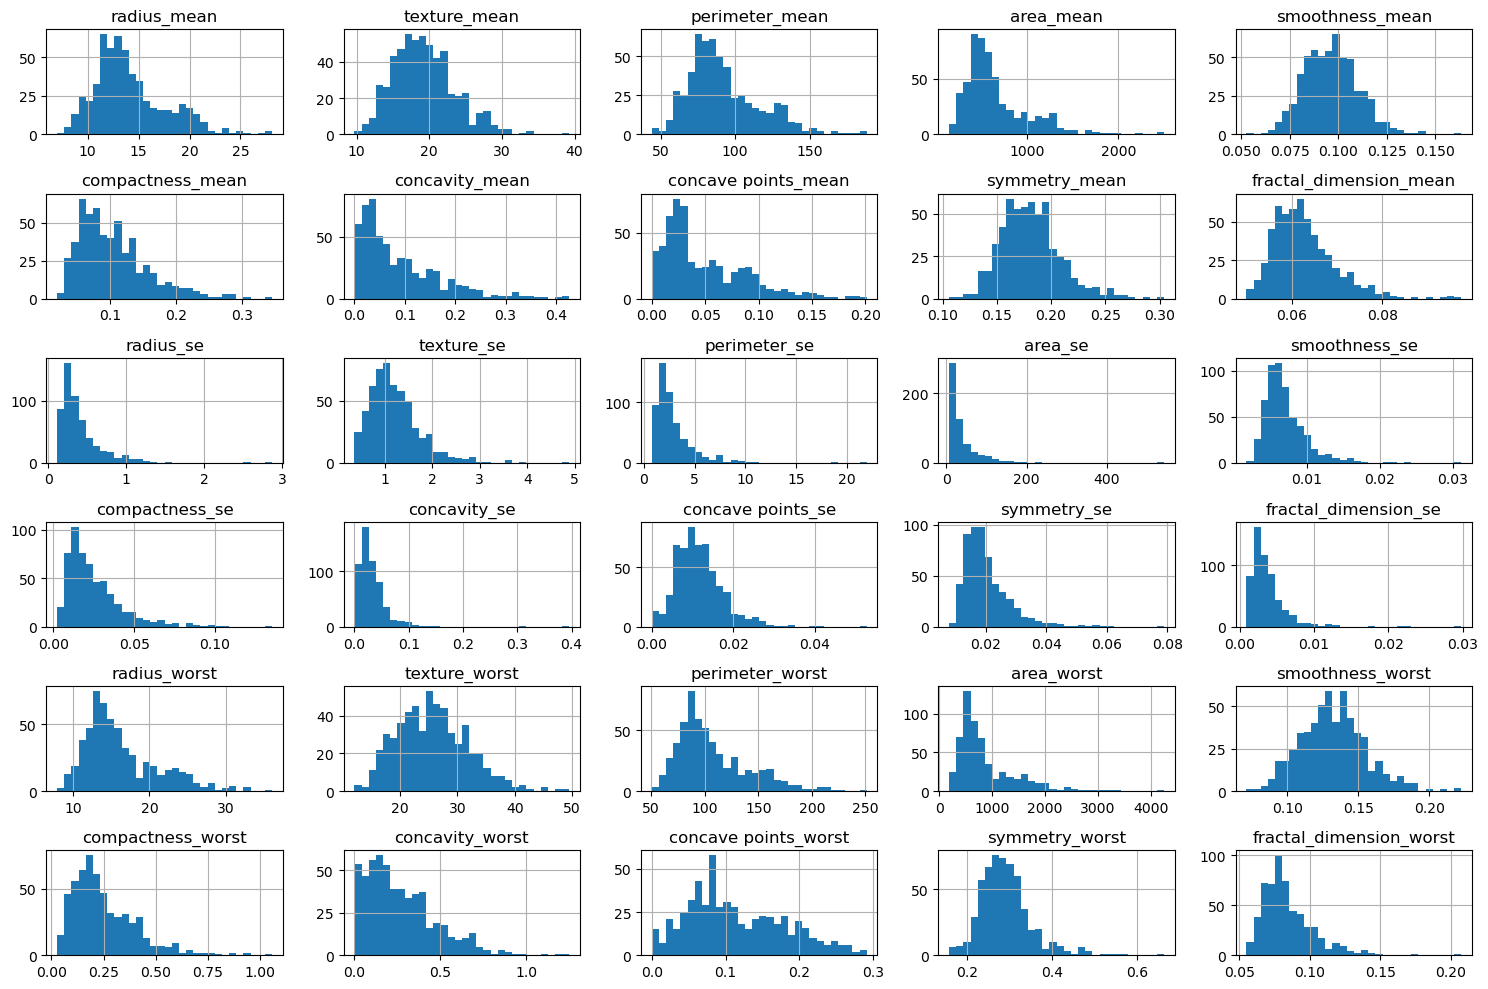

B    357
M    212
Name: diagnosis, dtype: int64


In [2]:
# Display summary statistics
print(df.describe())

# Visualize the distribution of features
import matplotlib.pyplot as plt

df.drop(['id'], axis=1).hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

# Check class balance
class_counts = df['diagnosis'].value_counts()
print(class_counts)

as reults shows the diagnosis column is a categorical field involves 357 observed 'B' value and 212 observed 'M' value. And due to histograms' right tail and std info which shows spread of numerical features (from around 0.02 to near 350) the data are not normal. Furthermore, from the displaying data the id field  doesn't seem is valuable and meaningful field for this assignment.

#### Preprocess data

in the following block to prepare the data for machine learning algorithms, the categorical target variable (diagnosis) is encoded to make it more suitable for modeling. Also the dataset into features (X) and the target variable (y) for further processing are splitted.

In [3]:
from sklearn.preprocessing import LabelEncoder

# Encode the diagnosis column (Malignant = 1, Benign = 0)
label_encoder = LabelEncoder()
df['diagnosis'] = label_encoder.fit_transform(df['diagnosis'])

# Split the data into features (X) and target variable (y)
X = df.drop(['id', 'diagnosis'], axis=1)
y = df['diagnosis']

As the above results show data are not normal, to improve the perfoemance of model features with high skewness (above 0.7) are identified and a power transformation is applied to those features. Finally, to ensure that features have similar scales, they scaled with StandardScaler to prevent of damage analysing because of big differences in the variance.

In [4]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler

# Calculating skewness of the features
skewness = X.skew()

# Selecting features with skewness above a threshold (0.7)
skewed_features = skewness[abs(skewness) > 0.7].index

# Applying power transformation 
power_transformer = PowerTransformer()
X_skewed = X[skewed_features].copy()
X_skewed_transformed = power_transformer.fit_transform(X_skewed)

# Replacing the original skewed features with the transformed features
X[skewed_features] = X_skewed_transformed

# Normalizing the features using standard scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


#### Modeling

This step is for selecting machine learning algorithms for classification. The following code experiments with a Decision Tree Classifier and a Gaussian Naive Bayes Classifier over breast cancer data. By using cross-validation with cross_val_score, the performance of each classifier using accuracy scores is estimated.

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

# Initialize the classifiers with different parameters
classifiers = [
    DecisionTreeClassifier(max_depth=1),
    GaussianNB()
]

# Train and evaluate the classifiers
for classifier in classifiers:
    scores = cross_val_score(classifier, X_scaled, y, cv=5)
    print(f'{classifier.__class__.__name__}: {scores.mean()}')

DecisionTreeClassifier: 0.8980903586399627
GaussianNB: 0.9402732494954199


The accuracy score represents the ratio of correctly predicted instances to the total number of instances for diagnosis target. The DecisionTreeClassifier results shows about 89.81% accuracy of the instances in the breast cancer dataset during cross-validation, meanwhile the the Gaussian Naive Bayes algorithm achieved an average accuracy score of around 0.9403. 

The higher accuracy of Gaussian Naive Bayes suggests that it might be better to the patterns present in the breast cancer dataset.

#### Evaluating

Accuracy alone might not provide a complete picture of model performance, especially in imbalanced datasets. To gain deeper insights, additional metrics (precision, recall, and F1-score using cross_val_predict) are used. These metrics give a better understanding of how well the models perform in terms of correctly classifying malignant 'M' and benign 'B' cases in the specific breast cancer data.

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict

# Perform cross-validation predictions
for classifier in classifiers:
    y_pred = cross_val_predict(classifier, X_scaled, y, cv=5)
    print(f'{classifier.__class__.__name__} metrics:')
    print(f'Accuracy: {accuracy_score(y, y_pred)}')
    print(f'Precision: {precision_score(y, y_pred)}')
    print(f'Recall: {recall_score(y, y_pred)}')
    print(f'F1-Score: {f1_score(y, y_pred)}')


DecisionTreeClassifier metrics:
Accuracy: 0.9015817223198594
Precision: 0.9105263157894737
Recall: 0.8160377358490566
F1-Score: 0.8606965174129354
GaussianNB metrics:
Accuracy: 0.9402460456942003
Precision: 0.9278846153846154
Recall: 0.910377358490566
F1-Score: 0.919047619047619


Comparing the metrics between the two models:

The Gaussian naive bayes model generally performs better across all metrics, with higher accuracy, (precision, recall, and F1-score) compared to the decision tree model.

The decision tree model has a slightly higher precision (indicating fewer false positives) but lower recall (indicating fewer true positives) compared to the gaussian model. 

The F1-scores for both models are quite close, shows that the both models have similar overall performance in terms of the balance between precision and recall.

In medical applications like breast cancer diagnosis, a higher recall might be more important than precision, as missing a true positive (a malignant 'M' case) can have serious consequences.

#### Explanation

Finally, a Decision Tree Classifier (with a maximum depth of 3) is fitted. Visualizing the decision tree helps to understand how the model makes decisions based on different features over diagnosis.

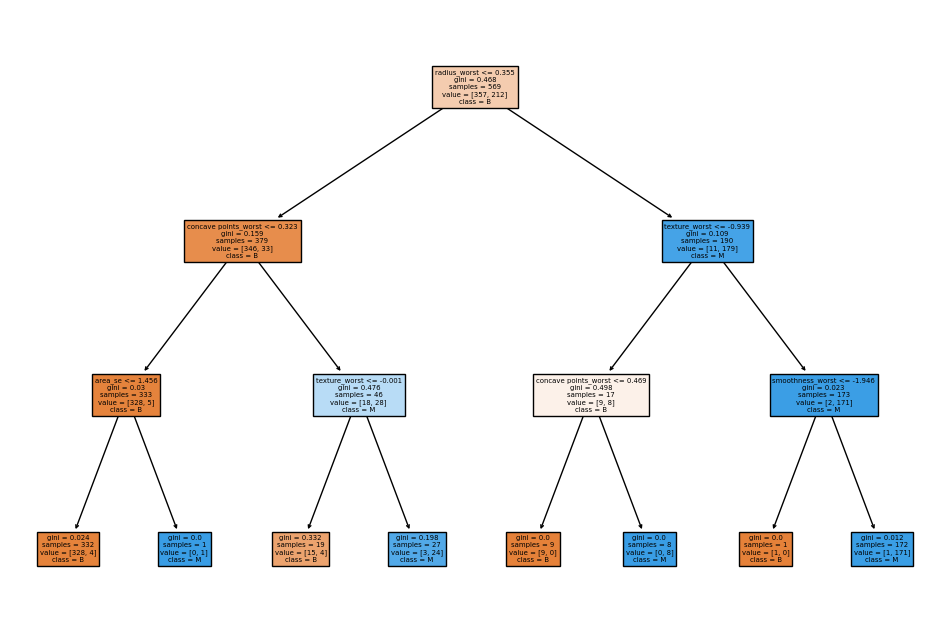

In [7]:
from sklearn.tree import plot_tree

# Create and fit a decision tree with max_depth=3
decision_tree = DecisionTreeClassifier(max_depth=3)
decision_tree.fit(X_scaled, y)

# Visualize the decision tree
plt.figure(figsize=(12, 8))
plot_tree(decision_tree, feature_names=X.columns, class_names=label_encoder.classes_, filled=True)
plt.show()


The decision tree visualization shows the structure of the decision tree model that has been trained on breast cancer dataset. Each node in the tree represents a decision based on a specific feature, and the branches leading to different nodes represent the possible outcomes of that decision.  

Nodes near the root play a significant role in making decisions.

in decision tree each node evaluates a specific feature and compares it against a threshold. If the feature value satisfies the condition, the algorithm follows the left branch. Otherwise, it follows the right branch. The process continues until reaching a leaf node, where the final prediction (Malignant 'M' or Benign 'B') is made.

Furthermore, the visualization uses colors to represent different classes (malignant 'M' class and benign 'B' class), to make it easier to see how instances are classified at different points in the tree.